In [1]:
!pip install matplotlib

In [2]:
import matplotlib.pyplot as plt

# Tokens embedding

## First get the tokenizer from the first part

In [3]:
import json
import regex

class Tokenizer:

    def __init__(self, tokenizer_path: str):
        with open(tokenizer_path) as f:
            tokenizer_data = json.load(f)
        split = next(filter(lambda t: t["type"] == "Split", tokenizer_data["pre_tokenizer"]["pretokenizers"]))
        self.split_regex = regex.compile(split["pattern"]["Regex"])

        # space is encoded as Ġ, for simplicity, just use space here.
        self.vocab = {k.replace("Ġ", " ").encode("utf-8"): v for k, v in tokenizer_data["model"]["vocab"].items()}
        added_tokens = {t["content"]: t["id"] for t in tokenizer_data["added_tokens"]}

        self.vocab.update(added_tokens)

        # inverse vocabulary for detokenization
        self.vocab_inv = { v: k for k, v in self.vocab.items() }

    def tokenize(self, text: str) -> list[int]:
        str_tokens = self.split_regex.findall(text)

        # Add specific markers for beginning and end of text
        str_tokens = ["<|begin_of_text|>"] + str_tokens + ["<|end_of_text|>"]

        tokens = []

        for str_token in str_tokens:
            parts = [bytes([b]) for b in str_token.encode("utf-8")]

            while True:
                # Iterate over all pairs and find the pair we want to merge the most
                min_idx = None
                min_rank = None
                for i, pair in enumerate(zip(parts[:-1], parts[1:])):
                    rank = self.vocab.get(pair[0] + pair[1])
                    if rank is not None and (min_rank is None or rank < min_rank):
                        min_idx = i
                        min_rank = rank

                # If there were no pairs we could merge, we're done!
                if min_rank is None:
                    break
                assert min_idx is not None

                # Otherwise, merge that pair and leave the rest unchanged. Then repeat.
                parts = parts[:min_idx] + [parts[min_idx] + parts[min_idx + 1]] + parts[min_idx + 2 :]

            tokens.extend(self.vocab[part] for part in parts)

        return tokens
    
    def detokenize(self, tokens: list[int]) -> str:
        decoded = b""
        for t in tokens:
            decoded += self.vocab_inv[t]

        return str(decoded)

In [4]:
tokenizer = Tokenizer("tokenizer.json")

In [5]:
tokenized_text = tokenizer.tokenize("This is a hello world")
print(tokenized_text)
detokenized_text = tokenizer.detokenize(tokenized_text)
print(detokenized_text)

[27, 91, 7413, 3659, 4424, 91, 29, 2028, 374, 264, 24748, 1917, 27, 91, 408, 3659, 4424, 91, 29]
b'<|begin_of_text|>This is a hello world<|end_of_text|>'


## Token embeddings

In [6]:
from pathlib import Path
import mmap
import numpy as np

def load_raw_model(path: str):
    model_dir = Path(path)
    model = {}
    with open(model_dir / "metadata.json") as file:
        metadata = json.load(file)
    for tensor_name, tensor_metadata in metadata.items():
        if tensor_name == "__metadata__":
            continue
        file = open(model_dir / f"{tensor_name}.raw", mode="rb")
        mmaped = mmap.mmap(file.fileno(), 0, prot=mmap.PROT_READ)
        model[tensor_name] = np.frombuffer(mmaped, dtype=np.float32).reshape(tensor_metadata["shape"])
    return model

In [7]:
tensors = load_raw_model("model")
with open("config.json") as file:
    config = json.load(file)

In [8]:
embed_tokens = tensors["model.embed_tokens.weight"]

In [9]:
# embeddings must be the same size than the tokenizer's vocabulary size
assert embed_tokens.shape[0] == len(tokenizer.vocab)
display(embed_tokens.shape)

(128256, 2048)

In [10]:
embed_tokens.max()

np.float32(0.34570312)

In [11]:
embedded_text = embed_tokens[tokenized_text]

(19, 2048)

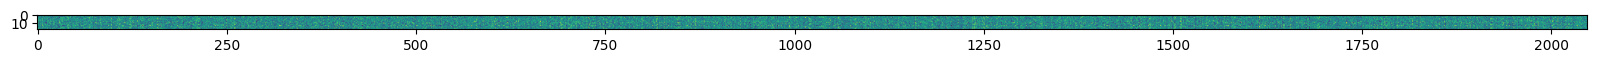

In [12]:
plt.figure(figsize = (20,1))
display(embedded_text.shape)
plt.imshow(embedded_text)

In [13]:
embedded_text.shape

(19, 2048)

## RMS Normalization

In [14]:
class RMSNorm:

    def __init__(self, weights, eps):
        self.weights = weights
        self.eps = eps

    def __call__(self, x):
        x_squared = x ** 2
        rms = np.sqrt(x_squared.mean() + self.eps)
        rms_norm = (x / rms) * self.weights
        return rms_norm

In [15]:
rmsnorm = RMSNorm(tensors["model.norm.weight"], config["rms_norm_eps"])

In [16]:
embedded_rmsnorm = rmsnorm(embedded_text[0])

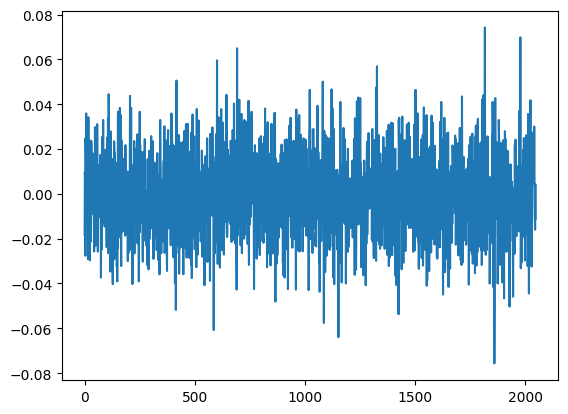

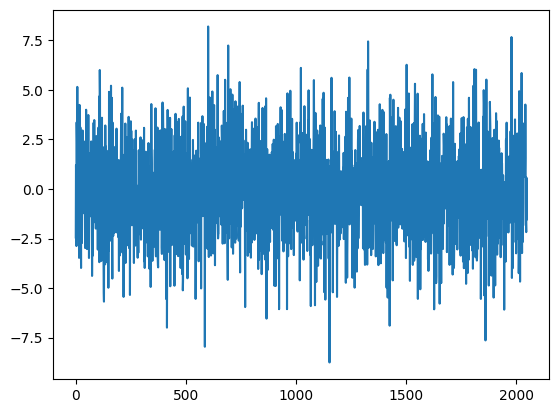

In [17]:
plt.plot(embedded_text[0])
plt.figure()
plt.plot(embedded_rmsnorm)

In [19]:
rmsnorm(embedded_text).shape

(19, 2048)

## Attention block

In [20]:
import math

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

def repeat_kv(x, n_rep: int):
    if n_rep == 1:
        return x
    return np.repeat(x, n_rep, axis=1)

class Attention:
    def __init__(self, tensors, layer_index, max_seq_len, config):
        self.num_key_value_heads = config["num_key_value_heads"]
        self.num_attention_heads = config["num_attention_heads"]
        self.repetitions = self.num_attention_heads // self.num_key_value_heads
        self.head_dim = config["head_dim"]

        self.q_weight = tensors[f"model.layers.{layer_index}.self_attn.q_proj.weight"].T
        self.k_weight = tensors[f"model.layers.{layer_index}.self_attn.k_proj.weight"].T
        self.v_weight = tensors[f"model.layers.{layer_index}.self_attn.v_proj.weight"].T
        self.o_weight = tensors[f"model.layers.{layer_index}.self_attn.o_proj.weight"].T

        self.cache_k = np.zeros((max_seq_len, self.num_key_value_heads, self.head_dim))
        self.cache_v = np.zeros((max_seq_len, self.num_key_value_heads, self.head_dim))


    def rope(self, xq, xk, freqs_cos, freqs_sin):
        # ["L or 1, QHN, HD"] -> ["L or 1, QHN,  HD//2, 2"]
        # split the last array dimension in two
        xqri = xq.reshape(xq.shape[:-1] + (-1, 2))
        xkri = xk.reshape(xk.shape[:-1] + (-1, 2))

        # Reshape `xq` and `xk` to match the complex representation.
        xq_r, xq_i = np.split(xqri, 2, axis=-1)
        xq_r = xq_r.squeeze(-1)
        xq_i = xq_i.squeeze(-1)

        xk_r, xk_i = np.split(xkri, 2, axis=-1)
        xk_r = xk_r.squeeze(-1)
        xk_i = xk_i.squeeze(-1)

        # Reshape `freqs_cos` and `freqs_sin` for broadcasting.
        freqs_cos = np.expand_dims(freqs_cos, axis=(0, 2))
        freqs_sin = np.expand_dims(freqs_sin, axis=(0, 2))

        # Apply rotation using real numbers.
        xq_out_r = xq_r * freqs_cos - xq_i * freqs_sin
        xq_out_i = xq_r * freqs_sin + xq_i * freqs_cos
        xk_out_r = xk_r * freqs_cos - xk_i * freqs_sin
        xk_out_i = xk_r * freqs_sin + xk_i * freqs_cos

        # Flatten last two dimensions.
        xq_out = np.stack([xq_out_r, xq_out_i], axis=-1)
        xk_out = np.stack([xk_out_r, xk_out_i], axis=-1)
        xq_out = xq_out.reshape(xq_out.shape[1:-2] + (-1,))
        xk_out = xk_out.reshape(xk_out.shape[1:-2] + (-1,))

        return xq_out, xk_out

    def __call__(self, x, start_pos: int, mask, freqs_cos, freqs_sin):
        input_length = x.shape[0]

        # QKV
        xq = x @ self.q_weight
        xk = x @ self.k_weight
        xv = x @ self.v_weight

        print(xq.shape, xk.shape, xv.shape)

        # L, QHN,  HD
        xq = xq.reshape((input_length, self.num_attention_heads, self.head_dim))
        # L, KVHN,  HD
        xk = xk.reshape((input_length, self.num_key_value_heads, self.head_dim))
        xv = xv.reshape((input_length, self.num_key_value_heads, self.head_dim))

        print(xq.shape, xk.shape, xv.shape)

        # RoPE #2
        xq, xk = self.rope(xq, xk, freqs_cos, freqs_sin)

        print(xq.shape, xk.shape, xv.shape)

        # KV Cache
        self.cache_k[start_pos: start_pos + input_length] = xk
        self.cache_v[start_pos: start_pos + input_length] = xv
        # L, KVHN,  HD
        ks = self.cache_k[: start_pos + input_length]
        vs = self.cache_v[: start_pos + input_length]

        # GQA
        # B, L, HN, HD
        xk = repeat_kv(ks, self.repetitions)
        xv = repeat_kv(vs, self.repetitions)

        print(xq.shape, xk.shape, xv.shape)

        # ["L, HN, HD"] -> ["HN, L, HD"]
        xq = xq.transpose(1, 0, 2)
        xk = xk.transpose(1, 0, 2)
        xv = xv.transpose(1, 0, 2)

        # Scaled Dot-Product Attention
        # ["HN, L or 1, HD"] @ ["HN, HD, L"] -> ["HN, L or 1, L"]
        attention = xq @ xk.transpose(0, 2, 1) / math.sqrt(self.head_dim)
        # `mask` is used only once at the beginning.
        if mask is not None:
            attention = attention + mask[None, :, :]
        attention = softmax(attention)
        output = attention @ xv

        # ["HN, L or 1, HD"] -> ["L or 1, D"]
        output = output.transpose(1, 0, 2).reshape(input_length, -1)
        output = output @ self.o_weight

        return output

In [21]:

def silu(x):
    return x * (1 / (1 + np.exp(-x)))

class FeedForward:
    def __init__(self, tensors, layer_index):
        self.up_weight = tensors[f"model.layers.{layer_index}.mlp.up_proj.weight"].T
        self.gate_weight = tensors[f"model.layers.{layer_index}.mlp.gate_proj.weight"].T
        self.down_weight = tensors[f"model.layers.{layer_index}.mlp.down_proj.weight"].T

    def __call__(self, x):
        swish = silu(x @ self.gate_weight)
        x_V = x @ self.up_weight
        x = swish * x_V
        x = x @ self.down_weight
        return x

In [22]:
class Transformer:
    def __init__(self, tensors, index, max_seq_len, config):
        self.attention = Attention(tensors, index, max_seq_len, config)
        self.feed_forward = FeedForward(tensors, index)
        self.input_layernorm = RMSNorm(
            tensors[f"model.layers.{index}.input_layernorm.weight"],
            eps=config["rms_norm_eps"]
        )
        self.post_attention_layernorm = RMSNorm(
            tensors[f"model.layers.{index}.post_attention_layernorm.weight"],
            eps=config["rms_norm_eps"]
        )

    def __call__(self, x, start_pos: int, mask, freqs_cos, freqs_sin):
        # RMSNorm
        norm_x = self.input_layernorm(x)
        # Masked Multi-Head Attention
        h1 = self.attention(norm_x, start_pos, mask, freqs_cos, freqs_sin)
        z = x + h1

        # RMSNorm
        norm_z = self.post_attention_layernorm(z)
        # Feed Forward + SwiGLU
        h2 = self.feed_forward(norm_z)
        out = z + h2

        return out


In [23]:
def compute_cos_sin_cache(head_dim: int, max_seq_len: int, base: int = 10000):
    inv_freq = 1.0 / (base ** (np.arange(0, head_dim, 2)[: (head_dim // 2)] / head_dim))
    t = np.arange(max_seq_len)
    freqs = np.outer(t, inv_freq)

    return np.cos(freqs), np.sin(freqs)

In [24]:
max_seq_len=50
max_new_tokens=max_seq_len-len(embedded_text)
freqs_cos, freqs_sin = compute_cos_sin_cache(config["head_dim"], max_seq_len, config["rope_theta"])

In [25]:
transformers = [ Transformer(tensors, index, max_seq_len, config) for index in range(config["num_hidden_layers"]) ]

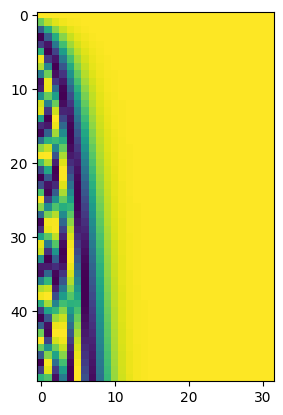

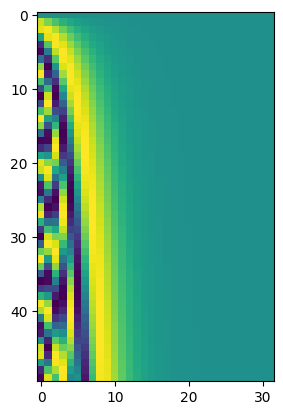

In [26]:
plt.imshow(freqs_cos)
plt.figure()
plt.imshow(freqs_sin)

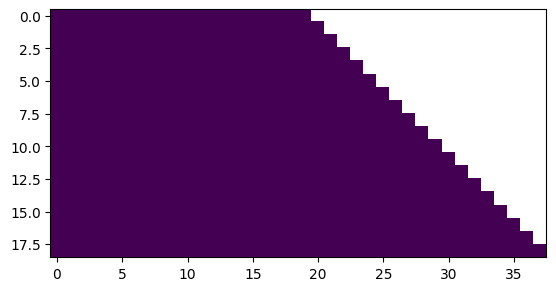

In [27]:
input_length = len(embedded_text)
start_pos = len(embedded_text)
freqs_cos = freqs_cos[start_pos: start_pos + input_length]
freqs_sin  = freqs_sin[start_pos: start_pos + input_length]

mask = np.full((input_length, input_length), float("-inf"))
mask = np.triu(mask, k=1)
mask = np.concatenate([np.zeros((input_length, start_pos)), mask], axis=1)

plt.imshow(mask)

In [28]:
em_txt = embedded_text[:]
for index, transformer in enumerate(transformers):
    print(f"transforming {index}")
    em_txt = transformer(em_txt, start_pos, mask, freqs_cos, freqs_sin)
    print(f"done with {index}")

transforming 0
(19, 2048) (19, 512) (19, 512)
(19, 32, 64) (19, 8, 64) (19, 8, 64)
(19, 32, 64) (19, 8, 64) (19, 8, 64)
(19, 32, 64) (38, 32, 64) (38, 32, 64)
done with 0
transforming 1
(19, 2048) (19, 512) (19, 512)
(19, 32, 64) (19, 8, 64) (19, 8, 64)
(19, 32, 64) (19, 8, 64) (19, 8, 64)
(19, 32, 64) (38, 32, 64) (38, 32, 64)
done with 1
transforming 2
(19, 2048) (19, 512) (19, 512)
(19, 32, 64) (19, 8, 64) (19, 8, 64)
(19, 32, 64) (19, 8, 64) (19, 8, 64)
(19, 32, 64) (38, 32, 64) (38, 32, 64)
done with 2
transforming 3
(19, 2048) (19, 512) (19, 512)
(19, 32, 64) (19, 8, 64) (19, 8, 64)
(19, 32, 64) (19, 8, 64) (19, 8, 64)
(19, 32, 64) (38, 32, 64) (38, 32, 64)
done with 3
transforming 4
(19, 2048) (19, 512) (19, 512)
(19, 32, 64) (19, 8, 64) (19, 8, 64)
(19, 32, 64) (19, 8, 64) (19, 8, 64)
(19, 32, 64) (38, 32, 64) (38, 32, 64)
done with 4
transforming 5
(19, 2048) (19, 512) (19, 512)
(19, 32, 64) (19, 8, 64) (19, 8, 64)
(19, 32, 64) (19, 8, 64) (19, 8, 64)
(19, 32, 64) (38, 32, 64)

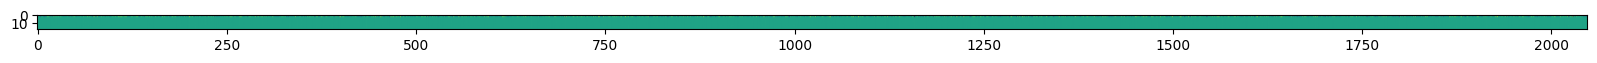

In [30]:
plt.figure(figsize = (20,1))
plt.imshow(em_txt)

In [26]:
att = Attention(tensors, 0, 50, config)
res = att(embedded_rmsnorm, start_pos, mask, freqs_cos, freqs_sin)
res.shape

(2048,) (512,) (512,)


ValueError: cannot reshape array of size 2048 into shape (2048,32,64)

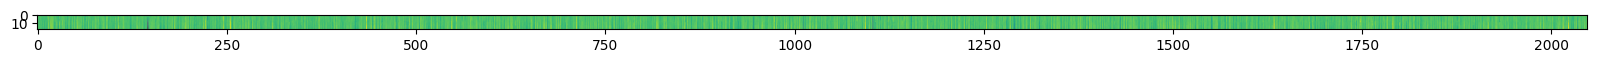

In [25]:
plt.figure(figsize = (20,1))
plt.imshow(res)

In [39]:
tokenizer.detokenize(res[-1, :].argmax(-1, keepdims=True))

"b'ces'"